## LSA & LDA
In this notebook, I will use the techniques of LSA and LDA in attempt to extract important terms and information between the recommended and non-recommended reviews for Elden Ring. I likely will have to adopt what I did in my Deep Learning notebook where I sample equal portions of recommended and non-recommended reviews in order to have balanced classes. However, the bigger reason is due to memory-related issues that could arise (though I wish I could efficiently make calculations based on all the data). 

First, I will start with LSA, and import the appropriate libraries as well as the dataset. I learned a lot from the sources I used to find out how to implement these algorithms, so be sure to check out those sources as they were very helpful.

## References:

* A very helpful article on how to implement LSA effectively in Python: https://towardsdatascience.com/latent-semantic-analysis-sentiment-classification-with-python-5f657346f6a3


* Great article about LDA and how to implement it in Python: https://towardsdatascience.com/topic-modelling-in-python-with-spacy-and-gensim-dc8f7748bdbf

In [176]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from pprint import pprint
import gc

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import spacy
import pyLDAvis.gensim_models
#import pyLDAvis.gensim #these two must already be in from spacy and from pyLDA
pyLDAvis.enable_notebook()
#import en_core_web_md
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore, CoherenceModel

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Eric\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [3]:
elden_ring_reviews = pd.read_csv("elden_ring_reviews_processed.csv") #If we have a truncated version, import as well.
elden_ring_reviews.drop(columns='Unnamed: 0', inplace=True) 

In [4]:
elden_ring_reviews['recommended'] = elden_ring_reviews['voted_up'].astype(int)

In [5]:
elden_ring_reviews.head()

,recommendationid,author,language,review,timestamp_created,timestamp_updated,voted_up,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,tokenized_texts,review_length,recommended
0,112052982,"{'steamid': '76561197971854668', 'num_games_ow...",english,First time with a Dark Souls type game and lov...,1647106589,1647106589,True,13373,1063,0.969001,0,True,False,False,"['time', 'dark', 'souls', 'type', 'game', 'lov...",108,1
1,111180228,"{'steamid': '76561198142415989', 'num_games_ow...",english,"The note said ""chest ahead"" at the edge of a c...",1645984692,1645984692,True,10448,6200,0.968309,144,True,False,False,"['note', 'say', 'chest', 'ahead', 'edge', 'cli...",161,1
2,111834761,"{'steamid': '76561197996565477', 'num_games_ow...",english,you can hug a woman,1646786974,1646786974,True,7580,2737,0.965731,81,False,False,False,"['hug', 'woman']",19,1
3,111321870,"{'steamid': '76561197977618010', 'num_games_ow...",english,If you rush you can make it the hardest Souls ...,1646160050,1646160090,True,4839,63,0.965078,0,True,False,False,"['rush', 'hard', 'souls', 'game', 'play', 'bit...",496,1
4,111347314,"{'steamid': '76561198101636446', 'num_games_ow...",english,"""Try jumping""\n*20 bloodstains surrounding the...",1646188418,1646188418,True,7403,3884,0.961223,0,True,False,False,"['try', 'jump', '20', 'bloodstain', 'surround'...",54,1


I'll repeat the process of making a balanced dataset here since we may change elements about it.

I will elect to use the truncated version of the dataframe in order to be safe with memory.

## LSA / Latent Semantic Analysis
We'll first make a TFIDF object to create and calculate term frequency metrics across all the text we're using.

In [7]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(elden_ring_reviews['review'])
#X = tfidf.transform(new_elden_ring_reviews['review'])

Let's try to look at the tfidf scores of some of the words. The higher the score, the more rare it is across the corpus of our texts.

In [8]:
print(elden_ring_reviews['review'][1])

The note said "chest ahead" at the edge of a cliff with nothing in sight...there were plenty of bloodstains but they must've missed the jump... I had to be sure



In [9]:
print([X[1, tfidf.vocabulary_['note']]])
print([X[1, tfidf.vocabulary_['chest']]])
print([X[1, tfidf.vocabulary_['bloodstain']]])

[0.2550650013626333]
[0.2545393289108085]
[0.0]


Since bloodstain is an element of interaction in the game, we can see it appears in the game's reviews commonly.

Our target variable is already in binary form, so we don't need to make any more converisons there.

We can now split our data into train and test splits.

In [47]:
X.shape

(155367,)

In [53]:
X = X[:, np.newaxis]

In [54]:
X.shape

(155367, 1)

In [55]:
y.shape

(155367,)

In [56]:
#we have equal amount of target reocrds, so no need for stratify

X = elden_ring_reviews.review
y = elden_ring_reviews.recommended

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)


In [57]:
X_train.shape

(116525,)

In [58]:
y_train.shape

(116525,)

In [59]:
X_test.shape

(38842,)

In [60]:
y_test.shape

(38842,)

Since we have equal class balance, we don't need to worry about which model/algorithm we use. We can carry on our use of Logistic Regression we made in a previous notebook detailing accuracy and other metrics when trying to predict sentiment.

Since it was the best of the three models we tried, we can use it again here, and perhaps try Random Forest and see if it gives better results. 

(The run time of Random Forest may depend on how much data we use, so it may only be used on the shorter dataframe).

In [43]:
cv = CountVectorizer()
clf = RandomForestClassifier(class_weight='balanced')
n_features = np.arange(10000, 30001, 10000)


In [208]:
#The below two functions are slightly modified versions of the original found in the reference at the top of the notebook.

def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    """
    This function takes a model pipeline as well as the training and testing sets of the data
    and calculates the model accuracy.
    
    args:
        pipeline (Pipeline object): the model pipeline to pass the data through
        X_train, y_train (Dataframe): the training data to be passed into the model
        y_train, y_test (Series): the testing data used to evaluate the model
        
    returns:
        accuracy (float): the accuracy score of the model performed
        
    
    """
    
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy


In [ ]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,30001,10000)

In [61]:

def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    """
    This function takes a vectorizer object as well as arguments for it to check and loop
    through calls to a random forest classifier at different numbers of features to check
    how accurate the model is at each value. 
    
    args:
        vectorizer (object): vectorizer object used on the data passed to the accurayc function
        n_features (range object): range of numbers to trial the n_feautres argument with when setting the vectorizer parameters
        stop_words (boolean): whether or not to phase out stop words
        ngram_range: (tuple): a range of values to set for the vectorizer to check how many ngrams to use
        classifier (object): the random forest classifier model used to train and evaluate influential words for sentiment
        
    returns:
        result (float): the accuracy of the model by using an iteration of set parameters
        best_range (int): the best value of n_features found that had the best accuracy returned
        
    
    """
    result = []
    print(classifier)
    print()
    
    best_value = 0
    best_range = 0
    
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        
        if nfeature_accuracy > best_value:
            best_value = nfeature_accuracy
            best_range = n
        
        result.append((n,nfeature_accuracy))
        
    return result, best_range



Result for trigram with stop words (Tfidf)

RandomForestClassifier(class_weight='balanced')


Test result for 10000 features
accuracy score: 93.53%
Test result for 20000 features
accuracy score: 93.50%
Test result for 30000 features
accuracy score: 93.37%
[(10000, 0.9352762473611039), (20000, 0.9349673034344267), (30000, 0.9337315277277174)]


In [ ]:
tfidf = TfidfVectorizer()
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt, best_n_range = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 3))

print(feature_result_tgt)

Depending on how good of accuracy we get, we choose that many features to carry over to make a classification report with.

In [62]:
cv = CountVectorizer(max_features=best_n_range, ngram_range=(1, 3))
pipeline = Pipeline([
    ('vectorizer', cv),
    ('classifier', clf)
])

sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['Not Recommended', 'Recommended']))



                 precision    recall  f1-score   support

Not Recommended       0.78      0.47      0.59      3850
    Recommended       0.94      0.98      0.96     34992

       accuracy                           0.93     38842
      macro avg       0.86      0.73      0.78     38842
   weighted avg       0.93      0.93      0.93     38842



## Chi2 - Relevant Term Selection
By performing this feature selection technique, we can extract and visualize some of the most relevant terms that distinguish between non-recommended and recommended reviews.

In [64]:
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))

#Converting to TfIdf to run through the chi2 method of sklearn
X_tfidf = tfidf.fit_transform(elden_ring_reviews['review'])
y = elden_ring_reviews['recommended']

chi2score = chi2(X_tfidf, y)[0]

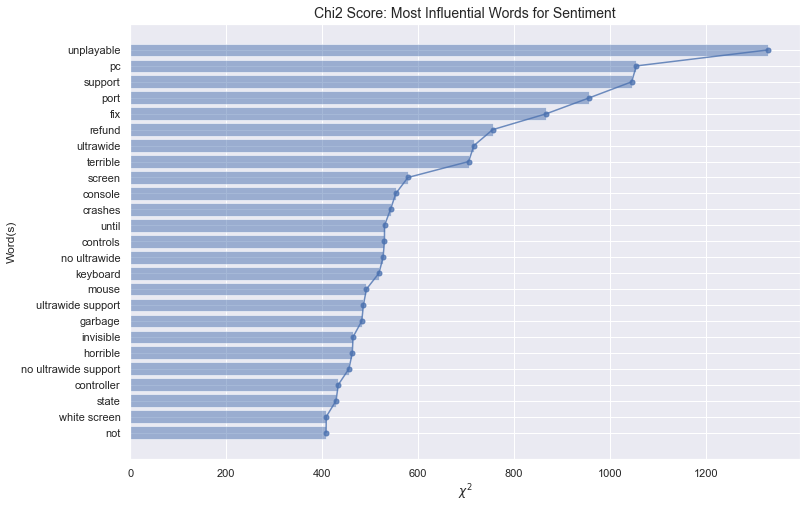

In [71]:
plt.figure(figsize=(12,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-25:]))
x = range(len(topchi2[1]))

#Plotting the top 25 influential terms on sentiment classification
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.title('Chi2 Score: Most Influential Words for Sentiment', fontsize=14)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.ylabel('Word(s)')
plt.show();

These terms above are the most influential and germane to the classes being distinguished between, those being reviews that are recommendations and non-recommendations.

We can see the words that distinguish the classes the most deal with the game's performance. The <i>Ultrawide</i> terms relate to the aspect ratio of the game on a computer monitor. Most of the other terms have to deal with the performance of the game, hence the terms white screen, crashes, and fix.

I don't believe using the RoBERTa PyTorch model would yield any differences here as far as getting more influential terms. This is binary classifier between positive and negative (recommended or not) sentiments, and since we have identified common and frequent terms that distinguish the non-recommended reviews, this model gets the job done.

From our LSA implementation, we can't peer into what topics are behind the words in our over-arching corpus from the reviews. This is where LDA can come in and help us with topic modeling.

Now let's dive into performing LDA on our data.

## LDA / Latent Dirichlet Analysis
We need to once again obtain a list of tokenized texts in our reviews. I'll use the same function from the data cleaning & processing notebook here.

In [75]:
extra_stop_words = ['\n', '\t']

texts = elden_ring_reviews.loc[:, 'review'].tolist()

In [76]:
nlp = spacy.load('en_core_web_sm')
nlp.Defaults.stop_words.update(extra_stop_words)

#removal = [] for now, we can keep the tags we have for now.


def review_tokenizer(text):
    return [token.lemma_.lower() for token in nlp(text) if not token.is_stop and not token.is_punct and str(token).isalnum()]

tokenized_texts = []

for i, text in enumerate(texts):
    
    if i % 500 == 0:
        print('Text: ', i)

    if pd.isnull(text):
        tokenized_texts.append(['NO REVIEW']) #maybe dashes are better than a word in order to distinguish
    else:
        tokenized_texts.append(review_tokenizer(text))

Text:  0
Text:  500
Text:  1000
Text:  1500
Text:  2000
Text:  2500
Text:  3000
Text:  3500
Text:  4000
Text:  4500
Text:  5000
Text:  5500
Text:  6000
Text:  6500
Text:  7000
Text:  7500
Text:  8000
Text:  8500
Text:  9000
Text:  9500
Text:  10000
Text:  10500
Text:  11000
Text:  11500
Text:  12000
Text:  12500
Text:  13000
Text:  13500
Text:  14000
Text:  14500
Text:  15000
Text:  15500
Text:  16000
Text:  16500
Text:  17000
Text:  17500
Text:  18000
Text:  18500
Text:  19000
Text:  19500
Text:  20000
Text:  20500
Text:  21000
Text:  21500
Text:  22000
Text:  22500
Text:  23000
Text:  23500
Text:  24000
Text:  24500
Text:  25000
Text:  25500
Text:  26000
Text:  26500
Text:  27000
Text:  27500
Text:  28000
Text:  28500
Text:  29000
Text:  29500
Text:  30000
Text:  30500
Text:  31000
Text:  31500
Text:  32000
Text:  32500
Text:  33000
Text:  33500
Text:  34000
Text:  34500
Text:  35000
Text:  35500
Text:  36000
Text:  36500
Text:  37000
Text:  37500
Text:  38000
Text:  38500
Text:  390

In [78]:
elden_ring_reviews['tokens'] = tokenized_texts

Now we'll make a dictionary based on the tokens we've just made.

In [80]:
dictionary = Dictionary(elden_ring_reviews['tokens'])

In [81]:
print(dictionary.token2id)

{'52': 0, 'apparently': 1, 'dark': 2, 'game': 3, 'good': 4, 'late': 5, 'love': 6, 'souls': 7, 'time': 8, 'type': 9, 'ahead': 10, 'bloodstain': 11, 'chest': 12, 'cliff': 13, 'edge': 14, 'jump': 15, 'miss': 16, 'note': 17, 'plenty': 18, 'say': 19, 'sight': 20, 'sure': 21, 'hug': 22, 'woman': 23, 'accordingly': 24, 'benchmark': 25, 'bit': 26, 'casual': 27, 'change': 28, 'content': 29, 'difficulty': 30, 'easy': 31, 'entire': 32, 'fit': 33, 'genre': 34, 'half': 35, 'hard': 36, 'level': 37, 'new': 38, 'old': 39, 'open': 40, 'opinion': 41, 'play': 42, 'player': 43, 'questing': 44, 'rush': 45, 'similar': 46, 'slow': 47, 'system': 48, 'think': 49, 'update': 50, 'way': 51, 'world': 52, '20': 53, 'message': 54, 'surround': 55, 'try': 56, 'busy': 57, 'elden': 58, 'indepth': 59, 'm': 60, 'review': 61, 'ring': 62, 'write': 63, 'contemplate': 64, 'great': 65, 'hop': 66, 'suicide': 67, 've': 68, 'improvement': 69, 'near': 70, 'need': 71, 'perfect': 72, 'performance': 73, 'ball': 74, 'crush': 75, 'enjo

In [82]:
#Filtering out low and high frequency words
#We'll keep the 1000 most frequent terms here

dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=1000)


In [84]:
#Creating the corpus using doc2bow from the dictionary object:

corpus = [dictionary.doc2bow(doc) for doc in elden_ring_reviews['tokens']]


Now we'll create the LDA model we imported from Gensim: 

In order to evaluate the model based on the number of topics chosen, we will use the coherence score to measure the degree of semantic similarity in the high scoring words. For the <i>u_mass</i> algorithm, the score returns in negative values.

We can simply run a for loop to try a number of different topics for the model to generate, and plot their coherence score performances to get an optimal number of topics to generate.

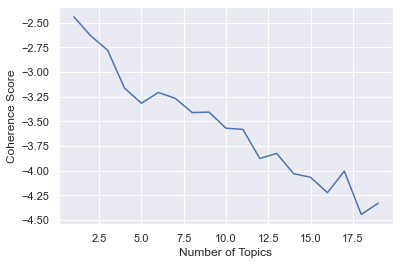

In [87]:
#Testing different number of topics and evaluating based on coherence score:
#We use the algorithm 'u_mass' to get the coherence score:

topics = []
score = []

for i in range(1, 20):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i, workers = 4, passes=10, random_state=3)
    co_model = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
    
    topics.append(i)
    score.append(co_model.get_coherence())
    
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

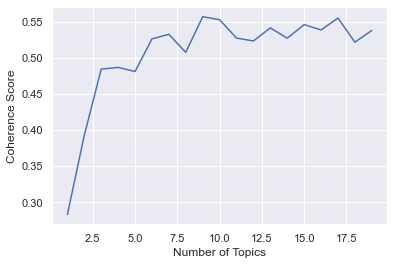

In [89]:
#Calculating coherence with c_v:

topics = []
score = []

for i in range(1, 20):
    lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=i, workers = 4, passes=10, random_state=3)
    co_model = CoherenceModel(model=lda_model, texts = elden_ring_reviews['tokens'], corpus=corpus, dictionary=dictionary, coherence='c_v')
    
    topics.append(i)
    score.append(co_model.get_coherence())
    
plt.plot(topics, score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')
plt.show()

When choosing which amount of topics to go with based on their metrics, there isn't a particular value to choose. We estimate based on the values returned by both algorithms, and usually higher scores are better.

I'll elect to choose 4 topics. We can always try other values if need be.

In [95]:
TOPICS = 4

In [96]:
#Creating a model using the topic amount yielding the highest coherence score:

lda_model = LdaMulticore(corpus=corpus, id2word=dictionary, iterations=100, num_topics=TOPICS, workers = 4, passes=100)

In [108]:
#Printing our the topics and their related words:

lda_model.print_topics()

[(0,
  '0.148*"good" + 0.059*"soul" + 0.057*"dark" + 0.050*"play" + 0.046*"souls" + 0.041*"like" + 0.023*"year" + 0.022*"world" + 0.022*"open" + 0.020*"love"'),
 (1,
  '0.041*"try" + 0.031*"die" + 0.027*"hour" + 0.022*"hole" + 0.021*"not" + 0.021*"finger" + 0.020*"play" + 0.020*"time" + 0.014*"yes" + 0.013*"kill"'),
 (2,
  '0.032*"issue" + 0.026*"elden" + 0.026*"ring" + 0.024*"pc" + 0.023*"fix" + 0.021*"performance" + 0.020*"run" + 0.017*"play" + 0.016*"stutter" + 0.015*"bad"'),
 (3,
  '0.034*"fun" + 0.030*"world" + 0.028*"great" + 0.022*"boss" + 0.021*"play" + 0.021*"hard" + 0.019*"open" + 0.019*"amazing" + 0.017*"like" + 0.013*"time"')]

In [98]:
lda_model[corpus][0]

[(0, 0.7702932), (1, 0.031861946), (2, 0.16418971), (3, 0.0336552)]

In [100]:
elden_ring_reviews['review'][0]

"First time with a Dark Souls type game and loving it. I am 52 so apparently it's never too late to get good."

In [209]:
print('Perplexity: {}'.format(lda_model.log_perplexity(corpus)))


Perplexity:  -6.019258424101727


These are the results for the first review in our dataset. It primarly relates to the topic of the game being positive and it relating to previous Dark Souls games.

Now we can use pyLDAVis to visualize our topics. The technique used to draw these circles is PCA, which we will also implement in addition to this.

We dpn't have any overlapping topics here. Two topics relate to positive sentiments about the game, one with its similarity to Dark Souls games, and another discussing Elden Ring's popular points, such as it being open world, having a beauitful aesthetic, and reinforcing good gameplay. Another topic discusses the negative elements of the game being performance related issues. The last topic includes some foul language, which we can attribute to players having a bad experience when things aren't going their way, hence the terms included being <i>'die'</i> and <i>'boss'<i/>.

In [101]:
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
pyLDAvis.display(lda_display)

We can save the topics by creating a new column in our dataframe and store the top topic values associated with each review.

In [102]:
elden_ring_reviews['topic'] = [sorted(lda_model[corpus][text])[0][0] for text in range(len(elden_ring_reviews['review']))]

In [103]:
elden_ring_reviews['topic'].value_counts()

0    153378
1      1320
2       605
3        64
Name: topic, dtype: int64

Since there are so many positive sentiments amongst our reviews, most of topics attributed come from the topic vaunting the game and it being alike to Dark Souls. 

We were still able to identify from these reviews the fact that performance issues is the main drawback to the gameplay experience. If there were any other major underlying issues with the product itself that had any consistency in the reviews on Steam, we would have discovered them. 

When applied to other domains, we can use this same technique to identify issues with something and address them. If there were any other prominent issues or different topics, the algorithm would have identified it as a semantically different focal point.

## Closing Remarks:

* Using Latent Semantic Analysis and $\chi^2$ Score, we were able to find the most influential terms that distinguish between recommended and non-recommended reviews. The words most infleuntail priamrily deal with performance issues of the game itself as well as screen ultrawide support for monitor resolution. Using this information, we identified what negative aspects of the game caused the most upheaval <b>among Steam reviews</b>.


* With Latent Dirichlet Analysis, we were able to find a few different overarching topics among the textual data. Though we created four topics, the primary split between positive and negative. One topic was about the performance issues of the game, while the positive topics relate to the best elements the game offers, such as the open world and its challenging bosses. The last topic wasn't too helpful, and by looking at the choice of words included, that topic stems from angry reviews of players dying and typing their rage on Steam reviews.